# Mountain Car Miniproject Tutorial Notebook

This notebook is here to guide you through the basics of the frameworks necessary for you to do well on your CS456-Miniproject 🤓

In [4]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import FancyArrowPatch
from matplotlib.patches import Patch

## Gymnasium environments

One of the main and most spread environment developer in the field of RL research is [Gymnasium](https://gymnasium.farama.org/). They provide standardized environments offering a large range of difficulties and setups, that are perfectly designed to benchmark performances of RL and Deep RL algorithms.

The main structure is very simple to understand. First, we need to instantiate our environment. We will use an existing environment, but one could also use their structure to design their own environment.

Let's directly work with the Mountain Car environment that will be used in the project. 

_PS: If you're more curious, feel free to browse the large list available on their website!_

In [5]:
env = gym.make('MountainCar-v0')

The environment contains an action space and an observation (state) space. Let's see what these look like.

In [6]:
print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")

Action space: Discrete(3)
Observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)


In [7]:
print(f"Number of actions available: {env.action_space.n}")
print(f"Observation shape: {env.observation_space.shape}")

Number of actions available: 3
Observation shape: (2,)


As we can see, the action space of that first environment is discrete and contains 3 possible actions: accelerate to the left, don't accelerate and accelerate to the right. 

The observation space has a dimension of 2, and you can find what each part represents [here](https://gymnasium.farama.org/environments/classic_control/mountain_car/#observation-space).

Before taking actions, the environment should be reset (or boostrapped). **Note: this should be done every time the environment has to be restarted, i.e., at the end of any episode.**

In [8]:
# the second return value is an info dictionary, but it doesn't contain anything in this environment
starting_state, _ = env.reset() 

print(f"Starting state: {starting_state}")

Starting state: [-0.4773635  0.       ]


Now that we know what the actions look like and that the environment is ready, we can take actions inside it. This is done using the `env.step` function, that takes an action as input, and returns multiple values. More details on each of them can be found [here](https://gymnasium.farama.org/api/env/#gymnasium.Env.step).

In the project, you will have an agent that will choose an action (based on the policy learned) given the current state. However, for now, we can simply sample actions at random using `action_space.sample()`.

In [9]:
action = env.action_space.sample()
print(f"Sampled action: {action}")
next_state, reward, terminated, truncated, _ = env.step(action) # again, the last return value is an empty info object

print(f"Next state: {next_state}")
print(f"Reward: {reward}")
print(f"Terminated: {terminated}")
print(f"Truncated: {truncated}")

Sampled action: 2
Next state: [-0.47670916  0.00065435]
Reward: -1.0
Terminated: False
Truncated: False


The `terminated` and `truncated`  variables represent the two ways that the episode might be done. Thus, it might be handy to use
```
done = terminated or truncated
```
in your code. 💡

We now have all the pieces necessary to run a full episode!

In [16]:
done = False
state, _ = env.reset()
episode_reward = 0

while not done:
    action = env.action_space.sample()
    next_state, reward, terimnated, truncated, _ = env.step(action)

    episode_reward += reward

    state = next_state
    done = terminated or truncated

print(f"Episode reward after taking random actions: {episode_reward}")

Episode reward after taking random actions: -200.0


Now your goal in the project will be to code an agent that can beat that 🙃

## Part 4 - Dyna

4.1 State discretization
In the mountain car environment, the state ranges from [−1.2, −0.07] to [0.6, 0.07]. To create a discrete state space, we divide the state space into bins. The bin sizes should differ for the two state dimensions.


In [17]:
num_bins = np.array([18,14]) # position and velocity

def discretize_state(state, state_space, num_bins):
    bin_sizes = (state_space.high - state_space.low) / num_bins
    return ((state - state_space.low) / bin_sizes).astype(int), bin_sizes

state = np.array([-0.5, 0.03])
discrete_state,__ = discretize_state(state, env.observation_space, num_bins)
print(discrete_state)

[7 9]


**4.2 Model building**
During training, the agent builds a model of the environment consisting of two key components: an estimation of transition probabilities Pˆs,a(s′) and an estimation of the reward for each state-action pair Rˆ(s, a). Pˆs,a(s′) represents the expected probability of transitioning to state s′ after taking action a in state s, while Rˆ(s, a) is the expected reward when taking action a in state s. These estimates are updated with each new observation.

**4.3 Implementation**

- make steps smaller (+ - didn't work)
- visualise the car (+)
- check the Q-values
- check the policy: doesn't always take the same action

- position increase reward
- remove truncation

In [34]:
# check

class DynaAgent:
    def __init__(self, state_space, action_space, discr_step=np.array([0.1, 0.01]), gamma=0.99, epsilon=0.9, k=10):
        self.discr_step = discr_step
        self.gamma = gamma
        self.epsilon = epsilon 
        self.k = k
        self.nstates = ((state_space.high - state_space.low) / self.discr_step).astype(int) + 1 # 1 is added to count upper bound as a separate state
        self.nactions = action_space.n
        self.P = np.ones((self.nstates[0], self.nstates[1], self.nactions, self.nstates[0], self.nstates[1])) / np.prod(self.nstates)
        #self.P = np.zeros((self.nstates[0], self.nstates[1], self.nactions, self.nstates[0], self.nstates[1]))
        self.R = np.zeros((self.nstates[0], self.nstates[1], self.nactions))
        self.Q = np.zeros((self.nstates[0], self.nstates[1], self.nactions))
        self.visits = np.zeros((self.nstates[0], self.nstates[1], self.nactions), dtype=int)
        self.learning_rate = 0.1
        self.position_list = []
        self.velocity_list = []
        self.delta_Q = []
        self.delta_t = 0.1

    def discretize_state(self, state):
        return ((state - state_space.low) / self.discr_step).astype(int)
    
    def update_model(self, s, a, r, s_prime):
        s_discrete = s #self.discretize_state(s)
        s_prime_discrete = s_prime #self.discretize_state(s_prime)
        self.visits[s_discrete[0], s_discrete[1], a] += 1
        self.learning_rate = 1 / self.visits[s_discrete[0], s_discrete[1], a]
        self.R[s_discrete[0], s_discrete[1], a] += self.learning_rate * (r - self.R[s_discrete[0], s_discrete[1], a])
        self.P[s_discrete[0], s_discrete[1], a, s_prime_discrete[0], s_prime_discrete[1]] += self.learning_rate # controls how much the Q-values are updated at each step while moving towards the minimum of a loss function
        self.P[s_discrete[0], s_discrete[1], a] /= np.sum(self.P[s_discrete[0], s_discrete[1], a]) # sum over s_prime for P equals to 1

    def update_Q_value(self, s, a):
        s_discrete =  s #self.discretize_state(s)
        # check if the contributions from P are sufficient
        future_rewards = self.P[s[0], s[1], a] * np.max(self.Q, axis=2) # Q shouldn't be one number
        self.Q[s_discrete[0], s_discrete[1], a] = self.R[s_discrete[0], s_discrete[1], a] + self.gamma * np.sum(future_rewards)
    
    def simulate(self):
        s_prime = np.zeros(2, dtype=int)
        for _ in range(self.k):
            # Randomly select a state-action pair from those that have been visited
            visited_states = np.where(self.visits > 0)
            #visited_states = np.where(self.state_action_state > 0)
            idx = np.random.choice(len(visited_states[0]))
            s = (visited_states[0][idx], visited_states[1][idx])
            a = visited_states[2][idx]

            # Retrieve the model for this state-action pair
            transition_probs= self.P[s[0], s[1], a]/ np.sum(self.P[s[0], s[1], a])
            # Pick a new state randomly based on the transition probabilities
            mat = np.repeat(np.arange(self.nstates[0])[:, np.newaxis], self.nstates[1], axis=1)
            chosen_index = np.random.choice(mat.flatten(), p=transition_probs.flatten())
            s_prime = np.unravel_index(chosen_index, shape=self.nstates)
            # Retrieve the reward for this state-action pair
            reward = self.R[s[0], s[1], a]
            # Find the maximum Q-value for the next state across all possible actions
            max_q_next = np.max(self.Q[s_prime[0], s_prime[1]])

            # Update Q-value using the learning rate, reward, and discount factor
            self.Q[s[0], s[1], a] += self.learning_rate * (reward + self.gamma * max_q_next - self.Q[s[0], s[1], a])


    def choose_action(self, state):
        """More random action in the beginning, more greedy towards the end"""
        if np.random.rand() < self.epsilon:
            return env.action_space.sample()
        else:
            s_discrete = state #self.discretize_state(state)
            return np.argmax(self.Q[s_discrete[0], s_discrete[1]])

    def decay_epsilon(self):
        self.epsilon *= 0.99  # Exponential decay
        self.epsilon = max(self.epsilon, 0.05)  # Ensuring epsilon does not go below 0.05

    def render(self, file_path='./mountain_car.mp4', mode='mp4'):
        """ When the method is called it saves an animation
        of what happened until that point in the episode.
        Ideally it should be called at the end of the episode,
        and every k episodes.
        
        ATTENTION: It requires avconv and/or imagemagick installed.
        @param file_path: the name and path of the video file
        @param mode: the file can be saved as 'gif' or 'mp4'
        """
        # Plot init
        fig = plt.figure()
        ax = fig.add_subplot(111, autoscale_on=False, xlim=(-1.2, 0.5), ylim=(-1.1, 1.1))
        ax.grid(False)  # disable the grid
        x_sin = np.linspace(start=-1.2, stop=0.5, num=100)
        y_sin = np.sin(3 * x_sin)
        # plt.plot(x, y)
        ax.plot(x_sin, y_sin)  # plot the sine wave
        # line, _ = ax.plot(x, y, 'o-', lw=2)
        dot, = ax.plot([], [], 'ro')
        # Initialize arrow
        arrow = FancyArrowPatch((0, 0), (0, 0), color='blue', arrowstyle='->', mutation_scale=20)
        ax.add_patch(arrow)

        time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
        _position_list = self.position_list
        _velocity_list = self.velocity_list
        _delta_t = self.delta_t

        def _init():
            dot.set_data([], [])
            time_text.set_text('')
            arrow.set_positions((0, 0), (0, 0))
            return dot, time_text, arrow

        def _animate(i):
            x = _position_list[i]
            v_x = _velocity_list[i]
            y = np.sin(3 * x)
            #v_y = 3 * np.cos(3 * x) * v_x
            dot.set_data(x, y)
            time_text.set_text("Time: " + str(np.round(i*_delta_t, 1)) + "s" + '\n' + "Frame: " + str(i))
            if i > 0:
                #dx = (self.position_list[i] - self.position_list[i-1]) / self.delta_t
                # Normalize the velocity vector for better visualization
                scale_factor = 25  # Adjust this factor to scale arrow size appropriately
                arrow.set_positions((x, y), (x + v_x * scale_factor, y))
            #arrow.set_positions((x, y), (x+v_x, y+v_y))
            return dot, time_text, arrow

        ani = animation.FuncAnimation(fig, _animate, np.arange(1, len(self.position_list)),
                                    blit=True, init_func=_init, repeat=False)
        if mode == 'gif':
            ani.save(file_path, writer='imagemagick', fps=int(1/self.delta_t))
        elif mode == 'mp4':
            ani.save(file_path, fps=int(1/self.delta_t), writer='ffmpeg', codec='libx264')
        # Clear the figure
        fig.clear()
        plt.close(fig)
    
# Usage
state_space = env.observation_space
action_space = env.action_space  # Assuming 3 possible actions
agent = DynaAgent(state_space, action_space)


In [40]:
# training
state, _ = env.reset()
episode_reward = 0
total_reward = 0
steps_per_episode = 500
store = {'Q': [],
         'R': [],
         'action': [],
         'state': [],
         'rewards': [],
         'delta_Q': []}

agent = DynaAgent(env.observation_space, env.action_space)
agent.position_list = [state[0]]
agent.velocity_list = [state[1]]
for episode in range(3000):
#while not done:
    state, _ = env.reset()
    state = agent.discretize_state(state)
    total_reward = 0
    done = False
    while not done:
        store['Q'].append(np.mean(agent.Q.copy()))
        store['R'].append(np.mean(agent.R.copy()))
        # Direct learning from environment interactions
        action = agent.choose_action(state)
        store['action'].append(action)
        next_state, reward, terminated, truncated, _ = env.step(action)
        agent.position_list.append(next_state[0])
        agent.velocity_list.append(next_state[1])
        next_state = agent.discretize_state(next_state)
        #print(f"Next state: {next_state}")
        store['state'].append(next_state)
        
        agent.update_Q_value(state, next_state, action) # ask why this is done before updating the model or try different configurations
        agent.update_model(state, action, reward, next_state)
        store['delta_Q'].append(np.abs(np.mean(agent.Q.copy()) - store['Q'][-1]))
        
        # Planning
        agent.simulate()

        total_reward += reward
        state = next_state

        done = terminated or truncated
        if done:
            break
    store['rewards'].append(total_reward)
    agent.decay_epsilon()
    print(f"Episode {episode + 1}: {total_reward}")

env.close()

print(f"Total reward: {total_reward}")

Episode 1: -200.0
Episode 2: -200.0
Episode 3: -200.0
Episode 4: -200.0
Episode 5: -200.0
Episode 6: -200.0
Episode 7: -200.0
Episode 8: -200.0
Episode 9: -200.0
Episode 10: -200.0
Episode 11: -200.0
Episode 12: -200.0
Episode 13: -200.0
Episode 14: -200.0
Episode 15: -200.0
Episode 16: -200.0
Episode 17: -200.0
Episode 18: -200.0
Episode 19: -200.0
Episode 20: -200.0
Episode 21: -200.0
Episode 22: -200.0
Episode 23: -200.0
Episode 24: -200.0
Episode 25: -200.0
Episode 26: -200.0
Episode 27: -200.0
Episode 28: -200.0
Episode 29: -200.0
Episode 30: -200.0
Episode 31: -200.0
Episode 32: -200.0
Episode 33: -200.0
Episode 34: -200.0
Episode 35: -200.0
Episode 36: -200.0
Episode 37: -200.0
Episode 38: -200.0
Episode 39: -200.0
Episode 40: -200.0
Episode 41: -200.0
Episode 42: -200.0
Episode 43: -200.0
Episode 44: -200.0
Episode 45: -200.0
Episode 46: -200.0
Episode 47: -200.0
Episode 48: -200.0
Episode 49: -200.0
Episode 50: -200.0
Episode 51: -200.0
Episode 52: -200.0
Episode 53: -200.0
Ep

In [36]:
print(agent.discretize_state([env.goal_position, env.goal_velocity]))

[17  7]


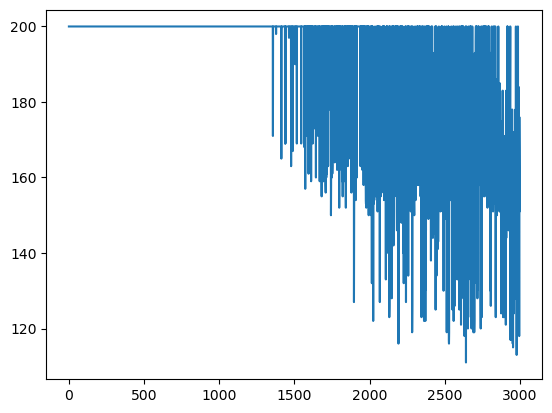

In [44]:
rewards_list = -np.array(store['rewards'])
plt.plot(rewards_list)

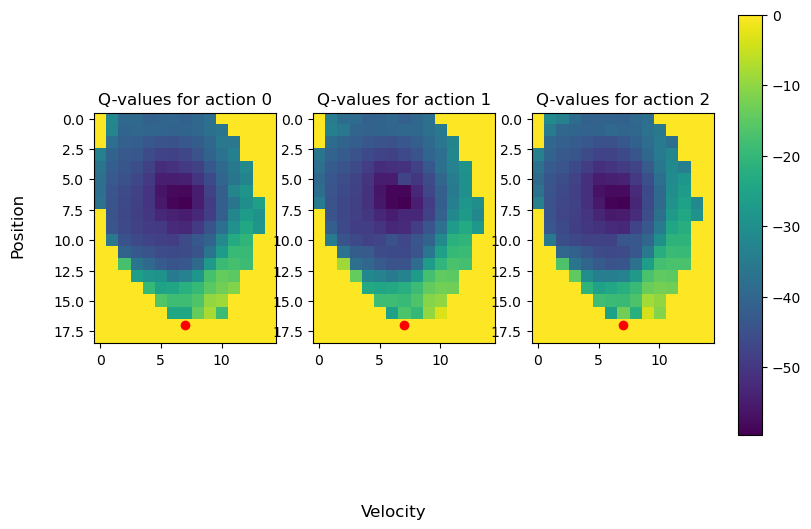

In [46]:
# Plotting the Q-values
fig, ax = plt.subplots(1, 3, figsize=(8, 6))
goal_position, goal_velocity = agent.discretize_state([env.goal_position,0])[0], agent.discretize_state([env.goal_position,0])[1]

# Display the Q-values for each action
im = ax[0].imshow(agent.Q[:, :, 0], cmap='viridis')
ax[0].scatter(goal_velocity, goal_position, color='red', label='Goal State')
ax[0].set_title('Q-values for action 0')

im = ax[1].imshow(agent.Q[:, :, 1], cmap='viridis')
ax[1].scatter(goal_velocity, goal_position, color='red', label='Goal State')
ax[1].set_title('Q-values for action 1')

im = ax[2].imshow(agent.Q[:, :, 2], cmap='viridis')
ax[2].scatter(goal_velocity, goal_position, color='red', label='Goal State')
ax[2].set_title('Q-values for action 2')

# Add a colorbar to the right of the subplots
cbar_ax = fig.add_axes([0.93, 0.15, 0.03, 0.7])  # Adjust these values as needed for proper positioning
fig.colorbar(im, cax=cbar_ax)
fig.supxlabel('Velocity')
fig.supylabel('Position')

# Adjust layout to make room for the colorbar
#fig.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()


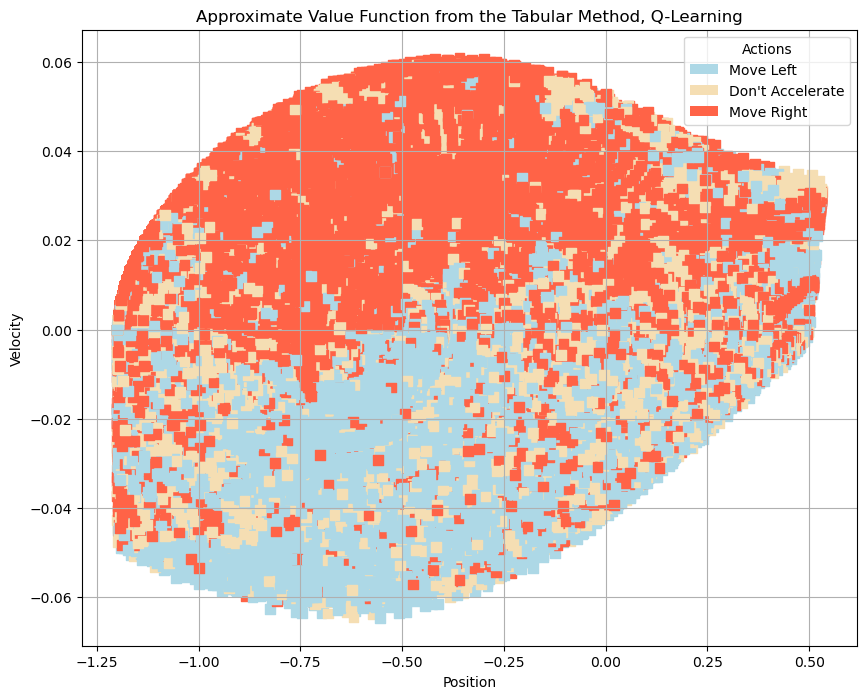

In [47]:
actions = np.array(store['action'])  # Randomly chosen actions for illustration
stacked_states = np.stack(store['state'])

# Map actions to colors
color_map = {0: 'lightblue', 1: 'wheat', 2: 'tomato'}  # Assume 0: Move Left, 1: Don't Accelerate, 2: Move Right
colors = np.empty(len(actions), dtype=object)  # Use dtype=object to store color names
for action, color in color_map.items():
    colors[actions == action] = color

# Create the plot
plt.figure(figsize=(10, 8))
#plt.scatter(stacked_states[:,0], stacked_states[:,1], c=colors.flatten(), marker='s', s=100)  # Flatten arrays
plt.scatter(agent.position_list[1:], agent.velocity_list[1:], c=colors.flatten(), marker='s', s=50)  # Flatten arrays

# Create a custom legend for actions
legend_elements = [Patch(facecolor=color_map[key], label=label) for key, label in {0: 'Move Left', 1: "Don't Accelerate", 2: 'Move Right'}.items()]
plt.legend(handles=legend_elements, title="Actions")

plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Approximate Value Function from the Tabular Method, Q-Learning')
plt.grid(True)
plt.show()


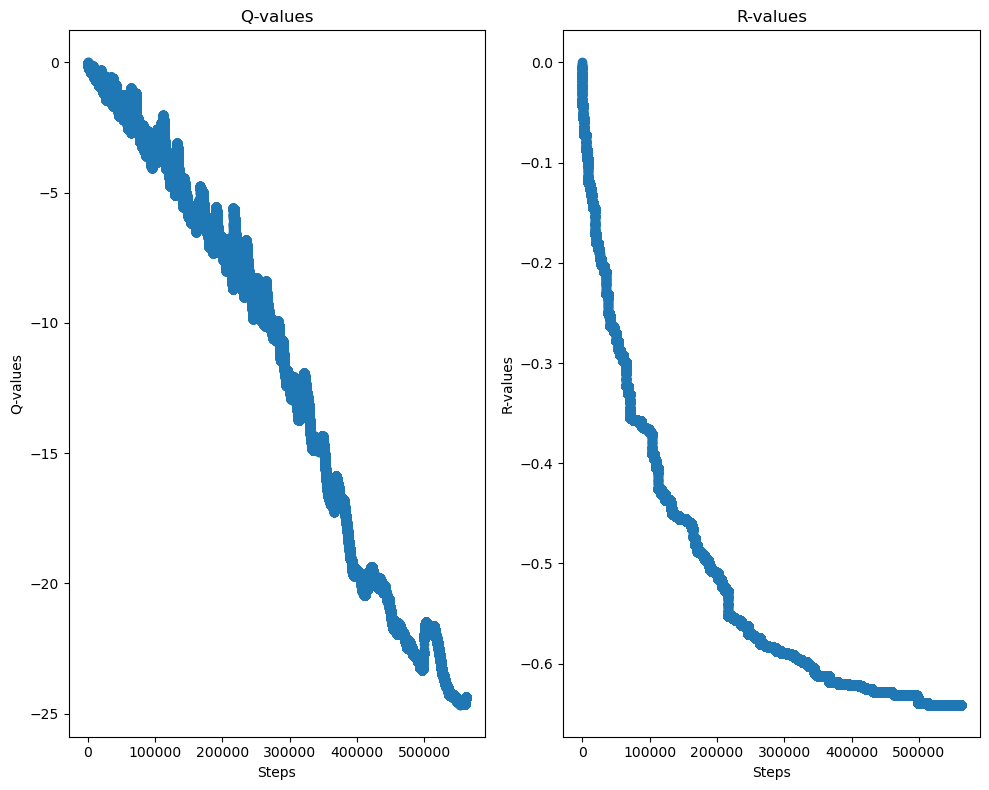

In [48]:
# plotting Q-values and R-values for episode
fig, ax = plt.subplots(1,2, figsize=(10, 8))
ax[0].scatter(np.arange(len(store['Q'])), store['Q'])
ax[0].set_title("Q-values")
ax[0].set_xlabel("Steps")
ax[0].set_ylabel("Q-values")
ax[1].scatter(np.arange(len(store['R'])), store['R'])
ax[1].set_title("R-values")
ax[1].set_xlabel("Steps")
ax[1].set_ylabel("R-values")

plt.tight_layout()
plt.show()

(562762,)


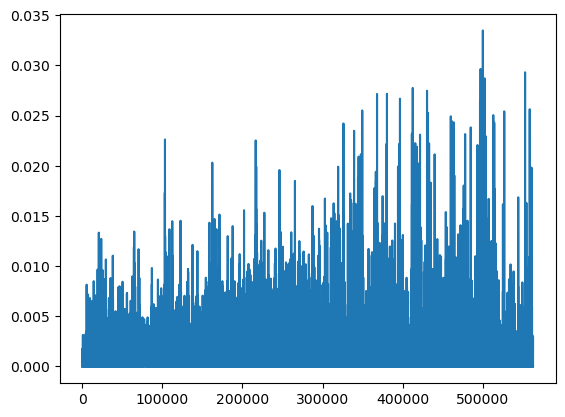

In [49]:
stacked_delta_Q = np.stack(store['delta_Q'])
print(stacked_delta_Q.shape)
plt.plot(stacked_delta_Q)

Plot the difference between two iterations: should converge to zero

Dyna is good because of initialisation

/var/folders/mg/44g5ch495hdc8x4_5mq3dsdm0000gn/T/ipykernel_17880/106899405.py:121: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  dot.set_data(x, y)


KeyboardInterrupt: 

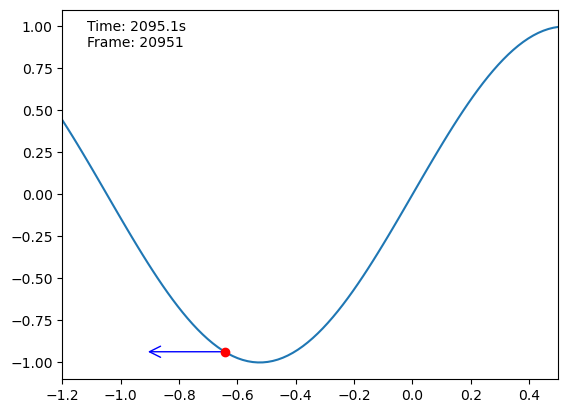

In [111]:
agent.render()

# Confusion
- Does dyna-Q agent follow the Q-learning? Is it fair to have the following update? q_table_sarsa[pos][vel][action] += alpha * (reward + gamma * q_table_sarsa[next_pos][next_vel][next_action] - q_table_sarsa[pos][vel][action])

"Though it looks simple, Mountaincar is actually pretty challenging because it's requires directed exploration. You exactly highlighted the difficulty: if it never sees the reward, it can't learn a good policy. Random exploration isn't enough, since the car won't gather the momentum needed.

To have it see the reward, you need to somehow incentivize it to visit new parts of the environment. For example, you could bucket the state space, and add something to the reward if you get to a state you haven't seen many times before. This is called "bonus-based exploration," and is an powerful general technique for learning in sparse-reward domains like this."

"That makes total sense, thank you.

I did end up adding a conditional to the main loop to check if the current state had a higher acceleration compared to the previous states seen and then if it did I added a small amount to the reward before updating the value function. I don't know if this specific method makes sense but before I was thinking that this kind of manipulation outside of the agents main logic would be kind of "cheating" since it used code beyond the expected sarsa implementation."

https://youtu.be/Lphlyuvocz0

In [ ]:
# Incentivizing model to visit new states  by rewarding the agent thorugh kinetic energy
        #reward +=  0.01 * (np.dot(next_state[1] + (action-1), next_state[1] + (action-1)))/2 
        #print(f"Next state: {next_state} and state: {state}")
        #print(f"Reward before tempering: {reward}")
        #if np.abs(next_state[1]) > np.abs(state[1]):
        #    print("Rewarding")
        #    reward += 1
        #if np.abs(next_state[0]) > np.abs(state[0]):
        #    print("Rewarding position")
        #    reward += 1